# Clasificador de Notas de Examen

## 1. Carga de Datos

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score

np.random.seed(42)

df = pd.read_csv("Datasets/Exam_Score_Prediction.csv")
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   student_id        20000 non-null  int64  
 1   age               20000 non-null  int64  
 2   gender            20000 non-null  object 
 3   course            20000 non-null  object 
 4   study_hours       20000 non-null  float64
 5   class_attendance  20000 non-null  float64
 6   internet_access   20000 non-null  object 
 7   sleep_hours       20000 non-null  float64
 8   sleep_quality     20000 non-null  object 
 9   study_method      20000 non-null  object 
 10  facility_rating   20000 non-null  object 
 11  exam_difficulty   20000 non-null  object 
 12  exam_score        20000 non-null  float64
dtypes: float64(4), int64(2), object(7)
memory usage: 2.0+ MB


### Justificación del Análisis Exploratorio

Analizando `info()` se observan muchas variables categóricas como `gender`, `course`, `sleep_quality`, etc. A estas variables se les realiza un preprocesamiento. 
La variable objetivo es `exam_score`.

## 2. Conjunto de Pruebas

Si hacemos un muestreo aleatorio, puede que el conjunto de pruebas no representa la población original. Para evitar este problemas se revisa la distribución de notas.

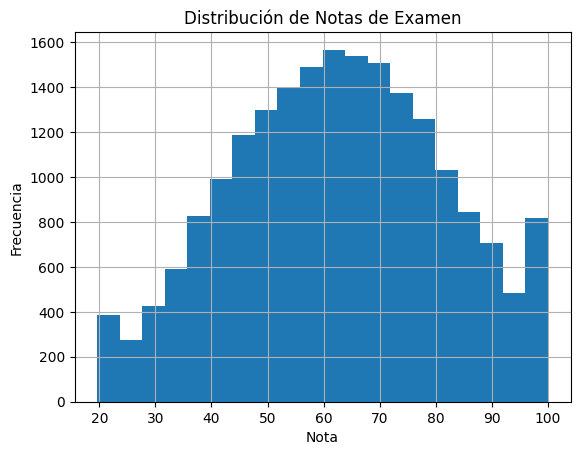

In [ ]:
df['exam_score'].hist(bins=20)
plt.title("Distribución de Notas de Examen")
plt.xlabel("Nota")
plt.ylabel("Frecuencia")
plt.show()

Además de la nota, es crucial que el test set tenga una proporción representativa de `gender` y `course`, ya que intuitivamente podrían influir en el resultado y queremos evitar sesgos.

Vamos a usar `StratifiedShuffleSplit` basándonos en una variable categórica "nota_cat" que crearemos para garantizar que haya alumnos de todos los niveles en ambos conjuntos.

In [ ]:
df['score_cat'] = pd.cut(df['exam_score'], 
                         bins=[0, 50, 60, 70, 80, 100], 
                         labels=[1, 2, 3, 4, 5])

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(df, df["score_cat"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

for set_ in (strat_train_set, strat_test_set):
    set_.drop("score_cat", axis=1, inplace=True)

students = strat_train_set.drop("exam_score", axis=1)
students_labels = strat_train_set["exam_score"].copy()
    
print(f"Tamaño conjunto de entrenamiento: {len(strat_train_set)}")
print(f"Tamaño conjunto de pruebas: {len(strat_test_set)}")

Tamaño conjunto de entrenamiento: 16000
Tamaño conjunto de pruebas: 4000


## 3. Preparación de los Datos y Pipeline

El dataset contiene una mezcla de variables numéricas y categóricas necesitan procesarse para poder trabajar con ellas.

**Decisiones de Preprocesamiento:**
1. **Escalado**: `StandardScaler` para algoritmos como SGD y SVM.
2. **Variables Categóricas**:
    - **Ordinales** (`sleep_quality`, `facility_rating`, `exam_difficulty`): Tienen un orden lógico (Malo < Medio < Bueno), por lo que usamos `OrdinalEncoder`.
    - **Nominales** (`gender`, `course`, `study_method`, `internet_access`): No tienen orden intrínseco, usaremos `OneHotEncoder`.

In [ ]:
num_attribs = ['age', 'study_hours', 'class_attendance', 'sleep_hours']
ord_attribs = ['sleep_quality', 'facility_rating', 'exam_difficulty']
cat_attribs = ['gender', 'course', 'study_method', 'internet_access']

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler()),
])

ordinal_categories = [
    ['poor', 'average', 'good'],      # sleep_quality
    ['low', 'medium', 'high'],        # facility_rating
    ['easy', 'moderate', 'hard']      # exam_difficulty
]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("ord", OrdinalEncoder(categories=ordinal_categories), ord_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

students_prepared = full_pipeline.fit_transform(students)
print(f"Dimensiones de los datos procesados: {students_prepared.shape}")

Dimensiones de los datos procesados: (16000, 24)


## 3.1. Clasificador Binario

El problema se puede simplificar en si el alumno aprobará o no, por lo que trabajaremos con el umbral de 50 puntos para el aprobado.

In [ ]:
y_train_pass = (students_labels >= 50)
y_train_pass.value_counts()

exam_score
True     11676
False     4324
Name: count, dtype: int64

Utilizaremos `SGDClassifier` (Stochastic Gradient Descent). Es eficiente y funciona bien como clasificador lineal base. Además, nos permitirá obtener puntuaciones de decisión para las curvas de precisión-cobertura más adelante.

In [ ]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(students_prepared, y_train_pass)

print("Predicción para el primer alumno:", sgd_clf.predict([students_prepared[0]]))

Predicción para el primer alumno: [False]


### Validación Cruzada

In [ ]:
cv_scores = cross_val_score(sgd_clf, students_prepared, y_train_pass, cv=3, scoring="accuracy")
print("Precisión:", cv_scores.mean())
cv_scores = cross_val_score(sgd_clf, students_prepared, y_train_pass, cv=3, scoring="recall")
print("Cobertura:", cv_scores.mean())

Precisión: 0.8578746473491864
Cobertura: 0.9228331620417952


## 4. Matriz de Confusión

Matriz de Confusión:
 [[ 2951  1373]
 [  901 10775]]


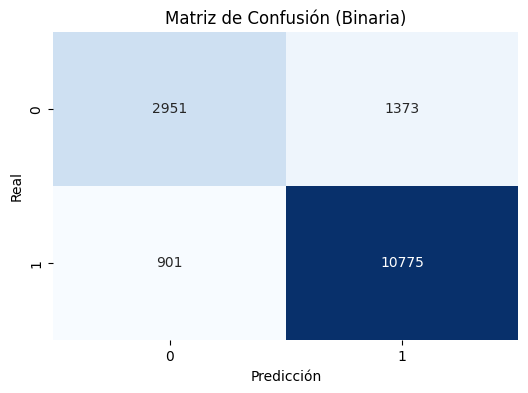

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, students_prepared, y_train_pass, cv=3)

cm = confusion_matrix(y_train_pass, y_train_pred)
print("Matriz de Confusión:\n", cm)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión (Binaria)')
plt.show()

Métricas derivadas de la matriz de confusión:
- **Precisión**: De los que dijimos que aprobarían, ¿cuántos aprobaron realmente?
- **Cobertura**: De los que realmente aprobaron, ¿cuántos detectamos?
- **F1**: Media armónica entre ambas.

In [ ]:
print("Precision:", precision_score(y_train_pass, y_train_pred))
print("Recall:", recall_score(y_train_pass, y_train_pred))
print("F1 Score:", f1_score(y_train_pass, y_train_pred))

Precision: 0.8869772802107343
Recall: 0.9228331620417951
F1 Score: 0.9045500335795836


## 5. Curvas de Precisión-Cobertura

Graficaremos cómo varían Precision y Recall para todos los umbrales posibles.

Ejemplos de scores: [-2.30354476  5.08591833  2.54126045  3.49965255  1.80959591]


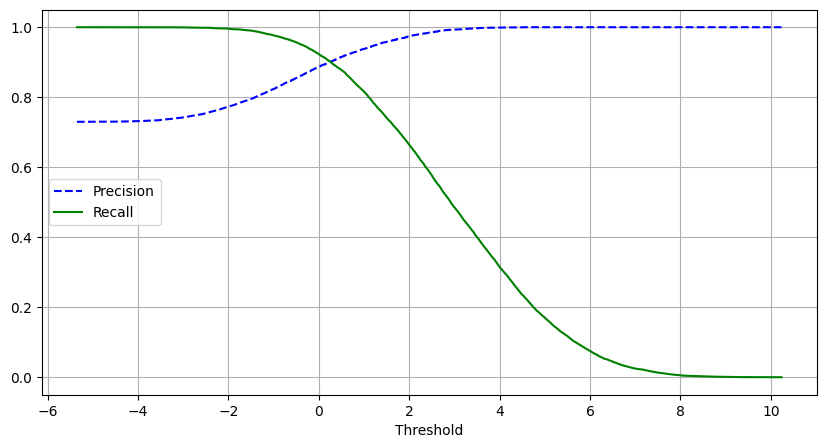

In [ ]:
y_scores = cross_val_predict(sgd_clf, students_prepared, y_train_pass, cv=3, method="decision_function")

print("Ejemplos de scores:", y_scores[:5])

precisions, recalls, thresholds = precision_recall_curve(y_train_pass, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.grid(True)

plt.figure(figsize=(10, 5))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

## 6. Umbral Óptimo y Curva PR

Podemos buscar el umbral que nos da un 90% de precisión o el que maximiza el F1 score.

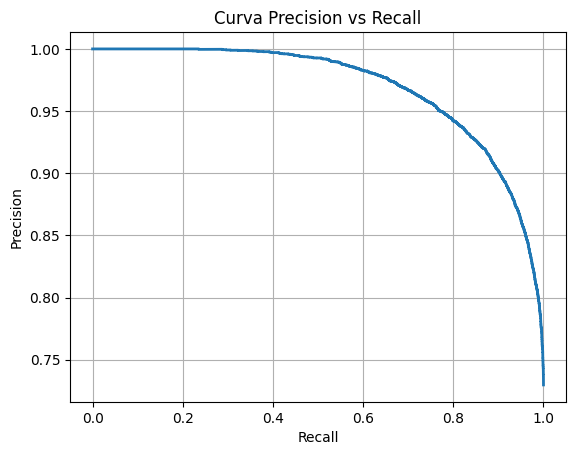

In [ ]:
plt.plot(recalls, precisions, linewidth=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision vs Recall")
plt.grid(True)
plt.show()

In [ ]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
print(f"Umbral para 90% precision: {threshold_90_precision}")

y_train_pred_90 = (y_scores >= threshold_90_precision)
print("Precision obtenida:", precision_score(y_train_pass, y_train_pred_90))
print("Recall obtenido:", recall_score(y_train_pass, y_train_pred_90))

Umbral para 90% precision: 0.23666844060521686
Precision obtenida: 0.9000085389804457
Recall obtenido: 0.9027064063035286


## 7. Curva ROC

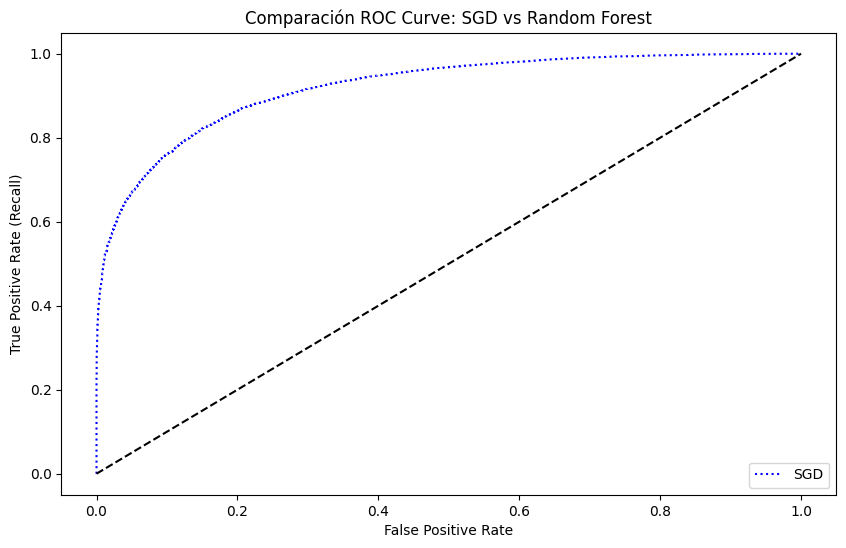

AUC SGD: 0.9195030192312383


In [ ]:
# SGD ROC
fpr, tpr, thresholds_roc = roc_curve(y_train_pass, y_scores)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, "b:", label="SGD")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.legend(loc="lower right")
plt.title("Curva ROC")
plt.show()

print("AUC SGD:", roc_auc_score(y_train_pass, y_scores))